#Feature Selection & Financial Variable Creation

This notebook employs precalculated aggregate data to determine drawdown and utilization rates for each current loan. Alongside these new features, feature engineering is applied to previously manually crafted features from two earlier kernels. The subsequent step involves feature reduction through various techniques.

The comprehensive feature set was established in the preceding two notebooks.

Three distinct methods will be employed for feature selection:

    Remove collinear features
    Remove features with greater than a threshold percentage of missing values
    Keep only the most relevant features using feature importances from a model

We will also take a look at an example of applying PCA although we will not use this method for feature reduction.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install featuretools

In [ ]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

We start by calling in only 1000 rows to identify collinear variables and decide which to remove. This is done for visualization purposes, the complete datasets are called later and have been premade due to being too computing power intensive to include with other code.

In [ ]:
# Read in data
train_bureau = pd.read_csv('/content/drive/MyDrive/Thesis/Home Credit Section/Preprocessing/train_bureau_raw.csv', nrows = 1000)
test_bureau = pd.read_csv('/content/drive/MyDrive/Thesis/Home Credit Section/Preprocessing/test_bureau_raw.csv', nrows = 1000)


train_previous = pd.read_csv('/content/drive/MyDrive/Thesis/Home Credit Section/Preprocessing/train_previous_raw.csv', nrows = 1000)
test_previous = pd.read_csv('/content/drive/MyDrive/Thesis/Home Credit Section/Preprocessing/test_previous_raw.csv', nrows = 1000)

# All columns in dataframes
bureau_columns = list(train_bureau.columns)
previous_columns = list(train_previous.columns)

In [ ]:
# Bureau only features
bureau_features = list(set(bureau_columns) - set(previous_columns))

# Previous only features
previous_features = list(set(previous_columns) - set(bureau_columns))

# Original features will be in both datasets
original_features = list(set(previous_columns) & set(bureau_columns))

print('There are %d original features.' % len(original_features))
print('There are %d bureau and bureau balance features.' % len(bureau_features))
print('There are %d previous Home Credit loan features.' % len(previous_features))

There are 122 original features.
There are 211 bureau and bureau balance features.
There are 1003 previous Home Credit loan features.


In [ ]:
train_labels = train_bureau['TARGET']
previous_features.append('SK_ID_CURR')

train_ids = train_bureau['SK_ID_CURR']
test_ids = test_bureau['SK_ID_CURR']

# Merge the dataframes avoiding duplicating columns by subsetting train_previous
train = train_bureau.merge(train_previous[previous_features], on = 'SK_ID_CURR')
test = test_bureau.merge(test_previous[previous_features], on = 'SK_ID_CURR')

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 1336)
Testing shape:  (1000, 1335)


In [ ]:
# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 1438)
Testing shape:  (1000, 1438)


In [ ]:
cols_with_id = [x for x in train.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in train.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in train.columns if 'SK_ID_PREV' in x]
print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))
print('There are %d columns that contain SK_ID_BUREAU' % len(cols_with_bureau_id))
print('There are %d columns that contain SK_ID_PREV' % len(cols_with_previous_id))

train = train.drop(columns = cols_with_id)
test = test.drop(columns = cols_with_id)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

There are 1 columns that contain SK_ID_CURR
There are 0 columns that contain SK_ID_BUREAU
There are 0 columns that contain SK_ID_PREV
Training shape:  (1000, 1437)
Testing shape:  (1000, 1437)


In [ ]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,1.000000,0.055960,0.036836,0.055732,0.035851,0.060210,0.303782,0.218535,0.211766,0.036960,...,0.096914,0.064817,0.024544,0.019465,0.005586,0.030986,0.001443,0.027967,0.004500,0.020465
AMT_INCOME_TOTAL,0.055960,1.000000,0.429317,0.491143,0.439981,0.184339,0.088743,0.208663,0.130682,0.045634,...,0.033574,0.064520,0.020186,0.058210,0.060465,0.080291,0.000218,0.043426,0.107476,0.030645
AMT_CREDIT,0.036836,0.429317,1.000000,0.797209,0.986046,0.074287,0.065100,0.116515,0.027876,0.022994,...,0.005136,0.011202,0.007313,0.060005,0.009795,0.098314,0.018123,0.009507,0.075595,0.009483
AMT_ANNUITY,0.055732,0.491143,0.797209,1.000000,0.799121,0.106685,0.019480,0.139220,0.059163,0.024020,...,0.011107,0.022890,0.017907,0.084270,0.022107,0.133969,0.036801,0.032497,0.098291,0.036308
AMT_GOODS_PRICE,0.035851,0.439981,0.986046,0.799121,1.000000,0.073531,0.058535,0.115613,0.034500,0.030878,...,0.002397,0.020737,0.000716,0.069845,0.014077,0.094081,0.012866,0.019114,0.082543,0.000395


In [ ]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,NaN,0.05596,0.036836,0.055732,0.035851,0.060210,0.303782,0.218535,0.211766,0.036960,...,0.096914,0.064817,0.024544,0.019465,0.005586,0.030986,0.001443,0.027967,0.004500,0.020465
AMT_INCOME_TOTAL,NaN,NaN,0.429317,0.491143,0.439981,0.184339,0.088743,0.208663,0.130682,0.045634,...,0.033574,0.064520,0.020186,0.058210,0.060465,0.080291,0.000218,0.043426,0.107476,0.030645
AMT_CREDIT,NaN,NaN,NaN,0.797209,0.986046,0.074287,0.065100,0.116515,0.027876,0.022994,...,0.005136,0.011202,0.007313,0.060005,0.009795,0.098314,0.018123,0.009507,0.075595,0.009483
AMT_ANNUITY,NaN,NaN,NaN,NaN,0.799121,0.106685,0.019480,0.139220,0.059163,0.024020,...,0.011107,0.022890,0.017907,0.084270,0.022107,0.133969,0.036801,0.032497,0.098291,0.036308
AMT_GOODS_PRICE,NaN,NaN,NaN,NaN,NaN,0.073531,0.058535,0.115613,0.034500,0.030878,...,0.002397,0.020737,0.000716,0.069845,0.014077,0.094081,0.012866,0.019114,0.082543,0.000395


In [ ]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 648 columns to remove.


In [ ]:
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 789)
Testing shape:  (1000, 789)


# Read in Full Dataset

In consideration of computational limitations, the approach will involve loading the fully merged and modified datasets. Past endeavors to replicate this process within extensive codebooks have resulted in recurrent crashing errors. Consequently, for these specific objectives, the merged dataset was created separately and then called.


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Thesis/Home Credit Section/Preprocessing/m_train_combined.csv')
test = pd.read_csv('/content/drive/MyDrive/Thesis/Home Credit Section/Preprocessing/m_test_combined.csv')

In [ ]:
print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 865)
Testing set full shape:  (48744, 864)



## Remove Missing Values

Opting for a relatively straightforward feature selection approach, the strategy involves removing columns with missing values. While this might appear simple, determining the minimum missing value threshold for column removal presents a challenge. In machine learning, such decisions lack definitive answers or universally applicable rules. In this implementation, columns exceeding a 75% missing value threshold will be eliminated.

Most models, including those in Sk-Learn, aren't designed to manage missing values. Consequently, pre-filling these gaps is necessary before applying machine learning. Notably, the Gradient Boosting Machine (such as LightGBM) can accommodate missing values. However, imputing missing values can be unsettling as it introduces information not inherently present in the dataset. Given the forthcoming evaluation of multiple models in a subsequent notebook, some form of imputation becomes essential. For now, the focus remains on removing columns surpassing the designated threshold.

In [ ]:
# Train missing values (in percent)
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing.head()

client_credit_AMT_PAYMENT_CURRENT_min_min            0.801438
client_credit_AMT_PAYMENT_CURRENT_mean_max           0.801438
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_mean    0.801178
client_credit_AMT_DRAWINGS_OTHER_CURRENT_mean_min    0.801178
client_credit_AMT_DRAWINGS_POS_CURRENT_mean_mean     0.801178
dtype: float64

In [ ]:
# Test missing values (in percent)
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
test_missing.head()

client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_max    0.773223
client_credit_AMT_DRAWINGS_OTHER_CURRENT_max_max     0.773223
client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_mean     0.773223
client_credit_AMT_DRAWINGS_POS_CURRENT_mean_mean     0.773223
client_credit_AMT_DRAWINGS_POS_CURRENT_min_min       0.773223
dtype: float64

In [ ]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 19 columns with more than 75% missing values


The following steps will be undertaken:

    Discard the specified columns.
    Perform one-hot encoding on the dataframes.
    Align the columns of the dataframes.

In [ ]:
# Need to save the labels because aligning will remove this column
train_labels = train["TARGET"]
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

train = pd.get_dummies(train.drop(columns = all_missing))
test = pd.get_dummies(test.drop(columns = all_missing))

train, test = train.align(test, join = 'inner', axis = 1)

print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 845)
Testing set full shape:  (48744, 845)


In [ ]:
train = train.drop(columns = ['SK_ID_CURR'])
test = test.drop(columns = ['SK_ID_CURR'])


#Feature Selection through Feature Importances

We have another feature selection approach available, focusing on the feature importances of a model. Tree-based models, including ensemble tree methods, calculate an "importance" for each feature by assessing the reduction in impurity achieved by incorporating that feature into the model. While the exact interpretation of importance values might not be straightforward, the relative values can serve as an indicator of feature relevance. Additionally, we can utilize these importances to exclude features that the model considers less significant.

One automatic method for this process is the Recursive Feature Elimination technique in Scikit-Learn. It requires an estimator (which can offer feature weights or importances) and a target number of features. The process involves iteratively fitting the model to the data, eliminating features with the lowest importances until the desired number is reached. This introduces another hyperparameter: the number of features to retain.

Alternatively, we can manually remove features by initially eliminating those with zero importance from the model. If this results in a surplus of features, we can contemplate the removal of those with the lowest importance values. For assessing feature importances, we'll employ a Gradient Boosted Model from the LightGBM library. If you're familiar with Scikit-Learn, you'll find that using LightGBM's API is quite similar to working with Scikit-Learn models.

Given that the LightGBM model doesn't necessitate imputed missing values, we can directly fit it to the training data. We'll utilize Early Stopping to identify the optimal number of iterations. To minimize the potential of overfitting to specific features, we'll run the model twice and average the feature importances.

In [ ]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

param = {
    "verbosee": 200,
    "early_stopping_round": 100
}

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'gbdt', n_estimators = 10000, class_weight = 'balanced')

In [ ]:
import re
train_model = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train_model.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,HOUSETYPE_MODE_specifichousing,HOUSETYPE_MODE_terracedhouse,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,0,202500.0,406597.5,24700.5,0.018801,-9461,-637,-3648.0,-2120,NaN,...,0,0,0,0,0,0,0,1,0,0
1,0,270000.0,1293502.5,35698.5,0.003541,-16765,-1188,-1186.0,-291,NaN,...,0,0,1,0,0,0,0,0,0,0
2,0,67500.0,135000.0,6750.0,0.010032,-19046,-225,-4260.0,-2531,26.0,...,0,0,0,0,0,0,0,0,0,0
3,0,135000.0,312682.5,29686.5,0.008019,-19005,-3039,-9833.0,-2437,NaN,...,0,0,0,0,0,0,0,0,0,0
4,0,121500.0,513000.0,21865.5,0.028663,-19932,-3038,-4311.0,-3458,NaN,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Fit the model twice to avoid overfitting
for i in range(2):

    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train_model, train_labels, test_size = 0.25, random_state = i)

    # Train using early stopping
    model.fit(train_features, train_y, eval_set = [(valid_features, valid_y)],
              eval_metric = 'auc')

    # Record the feature importances
    feature_importances += model.feature_importances_

[LightGBM] [Info] Number of positive: 18734, number of negative: 211899
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.385503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78977
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 836
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 18565, number of negative: 212068
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.408701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79042
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 835
[Light

In [ ]:
# Make sure to average feature importances!
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train_model.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
25,EXT_SOURCE_2,5274.0
26,EXT_SOURCE_3,4489.0
7,DAYS_REGISTRATION,3992.5
5,DAYS_BIRTH,3883.5
8,DAYS_ID_PUBLISH,3671.0


In [ ]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 79 features with 0.0 importance


,feature,importance
729,NAME_INCOME_TYPE_Unemployed,0.0
683,previous_loans_NFLAG_INSURED_ON_APPROVAL_min,0.0
684,client_credit_SK_DPD_DEF_min_min,0.0
385,previous_loans_NAME_PAYMENT_TYPE_Cashlessfromt...,0.0
551,previous_loans_NFLAG_LAST_APPL_IN_DAY_max,0.0


An encouraging outcome is that one of our features has secured a spot among the top 5 most important ones. This validates the effort invested in crafting these features. However, it's evident that several of the features we generated hold absolutely zero importance. In the context of a gradient boosting machine, features with 0 importance don't contribute to any splits. Consequently, these features can be safely eliminated from the model without impacting performance (except for expediting training time).

In [ ]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.

    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances

    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column

    """

    plt.rcParams['font.size'] = 18

    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align = 'center', edgecolor = 'k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance');
    plt.title('Cumulative Feature Importance');
    plt.show();

    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    return df

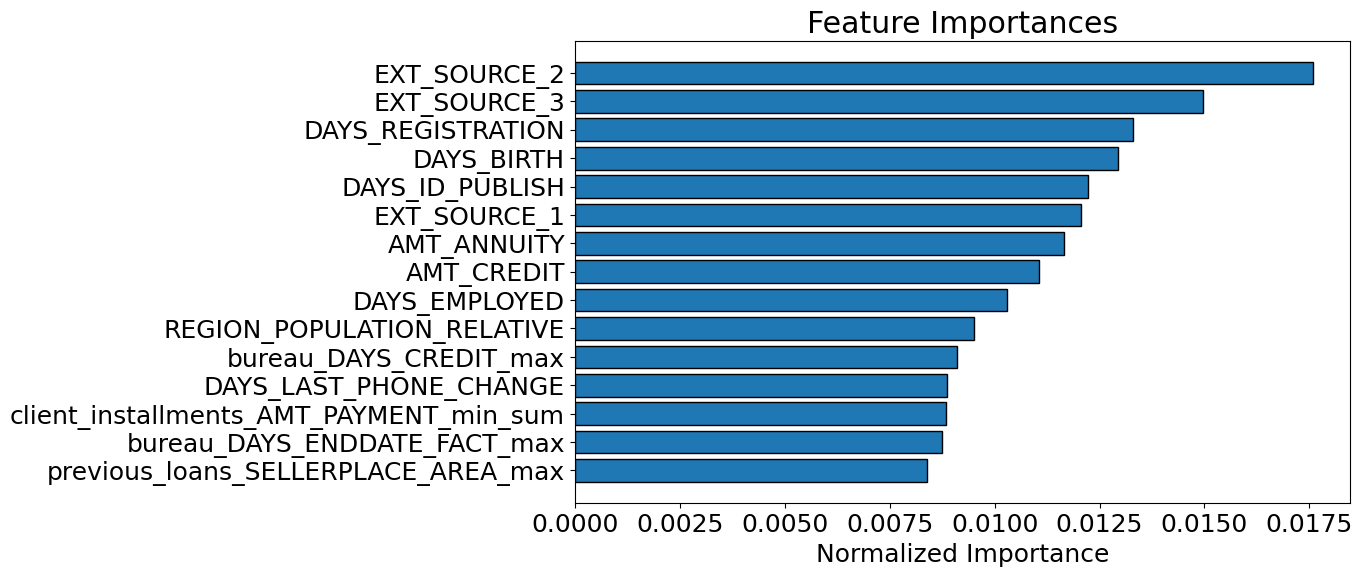

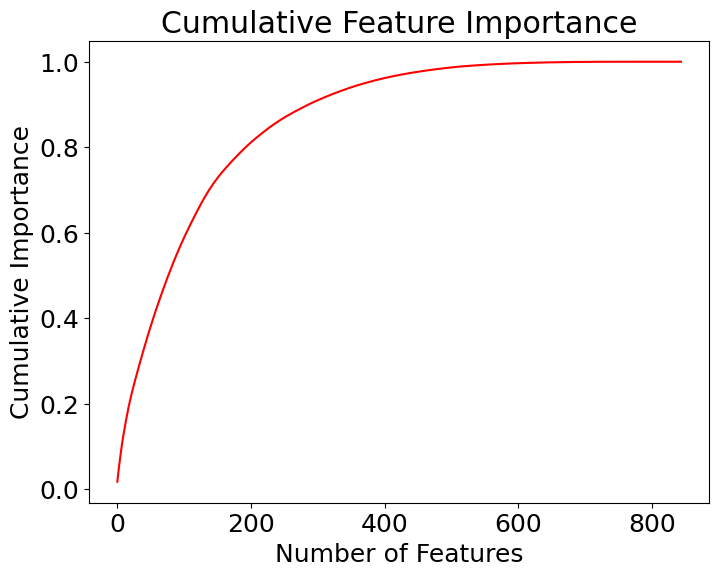

288 features required for 0.90 of cumulative importance


In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [ ]:
train_model.head()
test_model = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
train_model = train_model.drop(columns = zero_features)
test_model = test_model.drop(columns = zero_features)

print('Training shape: ', train_model.shape)
print('Testing shape: ', test_model.shape)

Training shape:  (307511, 765)
Testing shape:  (48744, 765)


Now, we have the opportunity to rerun the model to identify any additional features with zero importance. Essentially, we're conducting a personalized version of recursive feature elimination. Given the repetition involved, it's advisable to encapsulate the code for identifying features with zero importance within a function.

In [ ]:
def identify_zero_importance_features(train_model, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the
    feature importances from a gradient boosting model.

    Parameters
    --------
    train : dataframe
        Training features

    train_labels : np.array
        Labels for training data

    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """

    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train_model.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train_model, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, eval_set = [(valid_features, valid_y)],
                  eval_metric = 'auc')

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations

    feature_importances = pd.DataFrame({'feature': list(train_model.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))

    return zero_features, feature_importances

In [ ]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train_model, train_labels)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18734, number of negative: 211899
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.960704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78648
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 765
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set 

Presently, no features with zero importance remain (which aligns with our expectations). Should we wish to proceed with further feature reduction, the logical approach involves starting with features exhibiting non-zero importance. A viable strategy is to retain a sufficient number of features to encapsulate a specified threshold percentage of importance—let's say 95%. It's important to note that this decision is inherently arbitrary.

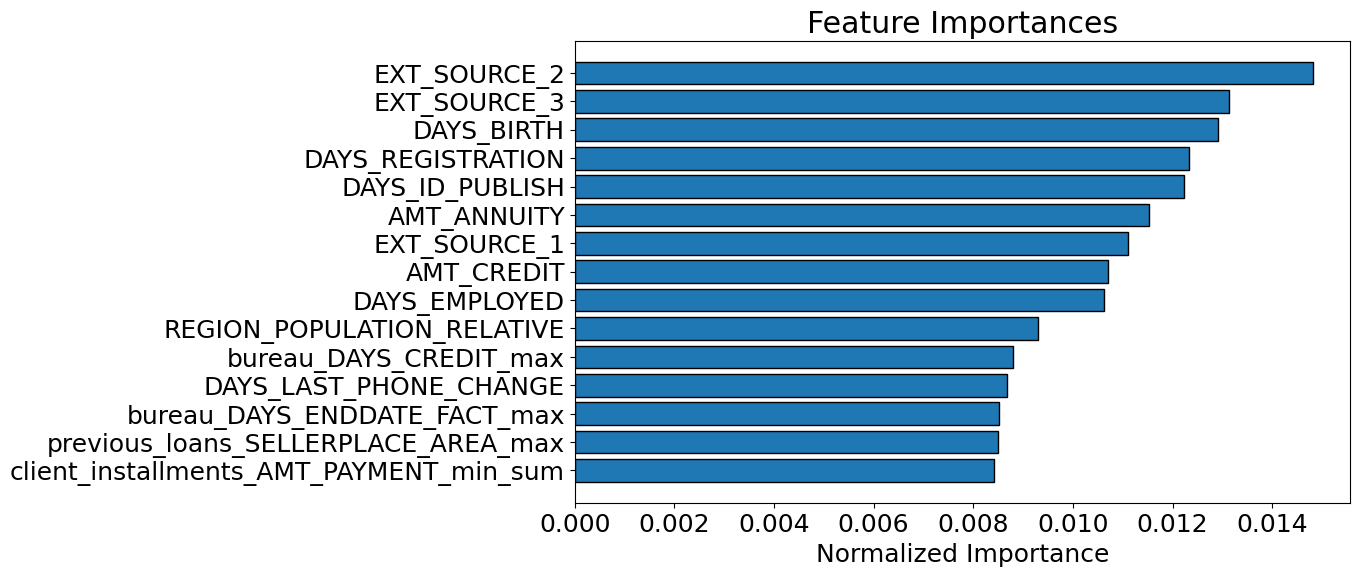

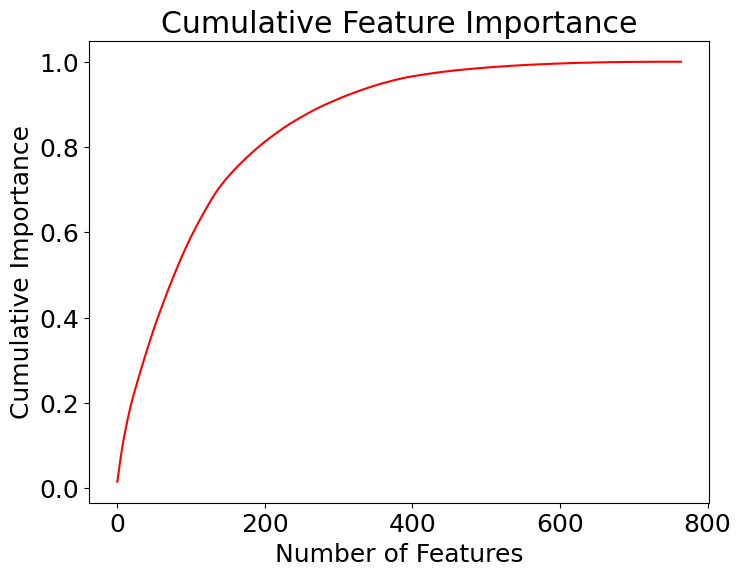

362 features required for 0.95 of cumulative importance


In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

To retain only the features contributing to 95% of the importance, we'll generate smaller copies of the dataset. Given that this step potentially poses the greatest risk to the model's learning capacity, we'll refrain from altering the original dataset. Instead, we'll create reduced-size versions and subsequently compare the performance of both datasets to assess the value of the additional feature removal step.

In [ ]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train_model[features_to_keep]
test_small = test_model[features_to_keep]

In [ ]:
train_small['TARGET'] = train_labels
train_small['SK_ID_CURR'] = train_ids
test_small['SK_ID_CURR'] = test_ids


# Test New Featuresets

The subsequent step involves evaluating the potential impact of the last feature removal process on the model. This can be achieved by employing a standard model and modifying the features accordingly.

We'll opt for a relatively standard LightGBM model, akin to the one utilized for feature selection. The primary divergence lies in the adoption of a five-fold cross-validation strategy for model training, with predictions being generated. While the code may seem extensive, it encompasses documentation and supplementary elements (like feature importances) that aren't strictly essential. For now, comprehending the entire model isn't imperative; the key point is that we're employing the same model on two distinct datasets to discern which one yields superior performance.


In [ ]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):

    """Train and test a light gradient boosting model using
    cross validation.

    Parameters
    --------
        features (pd.DataFrame):
            dataframe of training features to use
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame):
            dataframe of testing features to use
            for making predictions with the model.
        encoding (str, default = 'ohe'):
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation

    Return
    --------
        submission (pd.DataFrame):
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame):
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame):
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.

    """

    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']

    # Extract the labels for training
    labels = features['TARGET']

    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])


    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':

        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])

    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05,
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)

        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices)

        # Record the best iteration
        best_iteration = model.best_iteration_

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']

        valid_scores.append(valid_score)
        train_scores.append(train_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})

    return submission, feature_importances, metrics

# Test "Full" Dataset

This is the expanded dataset. To recap the process to make this dataset we:

    Removed collinear features as measured by the correlation coefficient greater than 0.9
    Removed any columns with greater than 80% missing values in the train or test set
    Removed all features with non-zero feature importances


In [ ]:
train_model['TARGET'] = train_labels
train_model['SK_ID_CURR'] = train_ids
test_model['SK_ID_CURR'] = test_ids
#fold_shuffle=True
submission, feature_importances, metrics = model(train_model, test_model)

Training Data Shape:  (307511, 765)
Testing Data Shape:  (48744, 765)
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 19919, number of negative: 226089
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.176083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78584
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 765
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as b

In [ ]:
metrics

,fold,train,valid
0,0,1.0,0.760004
1,1,1.0,0.758496
2,2,1.0,0.762528
3,3,1.0,0.760564
4,4,1.0,0.761396
5,overall,1.0,0.760603



## Test "Small" Dataset¶

The small dataset requires one additional step over the ful l dataset:

    Keep only features needed to reach 95% cumulative importance in the gradient boosting machine



In [ ]:
submission_small, feature_importances_small, metrics_small = model(train_small, test_small)

Training Data Shape:  (307511, 361)
Testing Data Shape:  (48744, 361)
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 19919, number of negative: 226089
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61924
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 361
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. Fo

In [ ]:
metrics_small

,fold,train,valid
0,0,1.000000,0.759753
1,1,0.999999,0.756923
2,2,1.000000,0.761393
3,3,1.000000,0.758450
4,4,1.000000,0.757574
5,overall,1.000000,0.758822


In [ ]:
print('Training shape: ', train_model.shape)
print('Testing shape: ', test_model.shape)

Training shape:  (307511, 767)
Testing shape:  (48744, 766)


In [ ]:
print('Training shape: ', train_small.shape)
print('Testing shape: ', test_small.shape)

Training shape:  (307511, 363)
Testing shape:  (48744, 362)


In [ ]:
train_small.sort_index()
test_small.sort_index()

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,AMT_ANNUITY,EXT_SOURCE_1,AMT_CREDIT,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,...,WEEKDAY_APPR_PROCESS_START_SATURDAY,client_cash_SK_DPD_mean_min,bureau_CREDIT_TYPE_Carloan_count_norm,previous_loans_NAME_GOODS_CATEGORY_ClothingandAccessories_count_norm,client_credit_AMT_CREDIT_LIMIT_ACTUAL_min_min,previous_loans_NAME_CONTRACT_STATUS_Approved_count,previous_loans_NAME_PRODUCT_TYPE_xsell_count,previous_loans_PRODUCT_COMBINATION_CashStreetmiddle_count_norm,NAME_CONTRACT_TYPE_Cashloans,SK_ID_CURR
0,0.789654,0.159520,-19241,-5170.0,-812,20560.5,0.752614,568800.0,-2329,0.018850,...,0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,1,100001
1,0.291656,0.432962,-18064,-9118.0,-1623,17370.0,0.564990,222768.0,-4469,0.035792,...,0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,1,100005
2,0.699787,0.610991,-20038,-2175.0,-3503,69777.0,NaN,663264.0,-4458,0.019101,...,0,0.0,0.5,0.0,45000.0,3.0,1.0,0.0,1,100013
3,0.509677,0.612704,-13976,-2000.0,-4208,49018.5,0.525734,1575000.0,-1866,0.026392,...,0,0.0,0.0,0.0,225000.0,3.0,1.0,0.0,1,100028
4,0.425687,NaN,-13040,-4000.0,-4262,32067.0,0.202145,625500.0,-2191,0.010032,...,0,0.0,NaN,0.0,NaN,1.0,1.0,0.0,1,100038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0.648575,0.643026,-19970,-9094.0,-3399,17473.5,NaN,412560.0,-5169,0.002042,...,0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,1,456221
48740,0.684596,NaN,-11186,-3015.0,-3003,31909.5,NaN,622413.0,-1149,0.035792,...,0,0.0,NaN,0.0,NaN,4.0,1.0,0.0,1,456222
48741,0.632770,0.283712,-15922,-2681.0,-1504,33205.5,0.733503,315000.0,-3037,0.026392,...,0,0.0,0.0,0.5,NaN,2.0,0.0,0.0,1,456223
48742,0.445701,0.595456,-13968,-1461.0,-1364,25128.0,0.373090,450000.0,-2731,0.018850,...,0,0.0,0.0,0.2,NaN,2.0,1.0,0.0,1,456224


In [ ]:
train_small = train_small.reindex(sorted(train_small.columns), axis=1)
test_small = test_small.reindex(sorted(test_small.columns), axis=1)

# Predictor Dataset

In [ ]:
#Predictor Dataset
predictor = pd.read_csv('/content/drive/MyDrive/Thesis/Home Credit Section/Final [Small]/predictor.csv')

#Unadulterated Dataset
application_train = pd.read_csv('/content/drive/MyDrive/Thesis/Home Credit Section/Input_Datasets/application_train.csv')
application_test = pd.read_csv('/content/drive/MyDrive/Thesis/Home Credit Section/Input_Datasets/application_test.csv')

In [ ]:
print('Application Training Dataset shape: ', application_train.shape)
print('Application Testing Dataset shape: ', application_test.shape)

Application Training Dataset shape:  (307511, 122)
Application Testing Dataset shape:  (48744, 121)


In [ ]:
train_small=pd.merge(train_small,predictor,on='SK_ID_CURR')
test_small=pd.merge(test_small,predictor,on='SK_ID_CURR')
train_model=pd.merge(train_model,predictor,on='SK_ID_CURR')
test_model=pd.merge(test_model,predictor,on='SK_ID_CURR')
application_train=pd.merge(application_train,predictor,on='SK_ID_CURR')
application_test=pd.merge(application_test,predictor,on='SK_ID_CURR')

In [ ]:
print('Small Training Dataset shape: ', train_small.shape)
print('Small Testing Dataset shape: ', test_small.shape)
print('Model Training Dataset shape: ', train_model.shape)
print('Model Testing Dataset shape: ', test_model.shape)
print('Application Training Dataset shape: ', application_train.shape)
print('Application Testing Dataset shape: ', application_test.shape)

Small Training Dataset shape:  (307511, 367)
Small Testing Dataset shape:  (48744, 366)
Model Training Dataset shape:  (307511, 771)
Model Testing Dataset shape:  (48744, 770)
Application Training Dataset shape:  (307511, 126)
Application Testing Dataset shape:  (48744, 125)


In [ ]:
path='/content/drive/MyDrive/Thesis/Home Credit Section/Final [Small]/'
#train_small.to_csv(path+'predictor_train_small.csv', index = False)
#test_small.to_csv(path+'predictor_test_small.csv', index = False)

In [ ]:
path='/content/drive/MyDrive/Thesis/Home Credit Section/Final [Small]/'
#train_model.to_csv(path+'predictor_train_medium.csv', index = False)
#test_model.to_csv(path+'predictor_test_medium.csv', index = False)

In [ ]:
path='/content/drive/MyDrive/Thesis/Home Credit Section/Final [Small]/'
#application_train.to_csv(path+'predictor_train_application.csv', index = False)
#application_test.to_csv(path+'predictor_test_application.csv', index = False)